<a href="https://colab.research.google.com/github/aminrabinia/StanceDetection_BLM/blob/master/BERT_Stance_Detection_by_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Stance Detection Using BERT-Fine-Tuning**

https://pysnacks.com/bert-text-classification-with-fine-tuning

In [2]:
#@title Install libraries
!pip install -q keras-bert keras-rectified-adam
%tensorflow_version 1.x


TensorFlow 1.x selected.


In [15]:
import os
import tensorflow as tf

os.environ['TF_KERAS'] = '1'

import codecs
import numpy as np
import pandas as pd

np.random.seed(1222)
tf.set_random_seed(1333)

from tensorflow.python import keras
import tensorflow.keras.backend as K

# Keras-bert imports
from keras_bert import Tokenizer
from keras_bert import get_custom_objects
from keras_bert import load_trained_model_from_checkpoint

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer



In [4]:
# @title Download models and data
!wget -q https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip -o uncased_L-12_H-768_A-12.zip

!wget -q http://alt.qcri.org/semeval2016/task6/data/uploads/stancedataset.zip 
!unzip -o stancedataset.zip

train_df = pd.read_csv('StanceDataset/train.csv', index_col=None, header=0, engine='python')
test_df = pd.read_csv('StanceDataset/test.csv', index_col=None, header=0, engine='python')

'''
from google.colab import files
data_upload=files.upload()

train_df= pd.read_csv('train.csv', index_col=None, header=0, engine='python')
test_df = pd.read_csv('test.csv', index_col=None, header=0, engine='python')
'''

print(train_df['Target'].value_counts())
print(test_df['Target'].value_counts())


Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  
Archive:  stancedataset.zip
   creating: StanceDataset/
  inflating: StanceDataset/test.csv  
   creating: __MACOSX/
   creating: __MACOSX/StanceDataset/
  inflating: __MACOSX/StanceDataset/._test.csv  
  inflating: StanceDataset/train.csv  
  inflating: __MACOSX/StanceDataset/._train.csv  
Hillary Clinton                     689
Feminist Movement                   664
Legalization of Abortion            653
Atheism                             513
Climate Change is a Real Concern    395
Name: Target, dtype: int64
Donald Trump                        707
Hillary Clinton                     295
Feminist Movement       

In [16]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
stop_words=stop_words-set(['no','not'])
stemmer = SnowballStemmer('english')

def clean_my_text(line):
  line = re.sub(r'http\S+', '', line)
  line= re.sub('[#,@,/,&,0-9,\n,\t]',' ', line)
  #line= re.sub('([A-Z])', r' \1', line)
  return line

def remove_stop(line):
  temp= " ".join([stemmer.stem(s) for s in line.split() if s not in stop_words])
  return temp

raw_docs_train=[]
classlabels_train=[]

raw_doc_test=[]
classlabel_test=[]

Target='Donald Trump'

for i,row in train_df.iterrows():
  if row[1]: 
    raw_docs_train.append( row['Tweet'])
    classlabels_train.append( row['Stance'])
for i, row in test_df.iterrows():
  if row[1]!= Target: 
    raw_docs_train.append( row['Tweet'])
    classlabels_train.append( row['Stance'])

for i,row in train_df.iterrows():
  if row[1]: 
    raw_docs_train.append(remove_stop(row['Tweet']))
    classlabels_train.append( row['Stance'])
for i, row in test_df.iterrows():
  if row[1]!= Target: 
    raw_docs_train.append(remove_stop(row['Tweet']))
    classlabels_train.append( row['Stance'])

print('train and validation size:',len(classlabels_train))

for i,row in test_df.iterrows():
  if row[1]==Target: 
    raw_doc_test.append( row['Tweet'])
    classlabel_test.append( row['Stance'])
    
print('test size:',len(classlabel_test))

map_st = {'NONE':2,
        'AGAINST':1,
        'FAVOR':0}
labels_tr=[map_st[x] for x in classlabels_train]
labels_ts=[map_st[x] for x in classlabel_test]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
train and validation size: 8326
test size: 707


In [18]:
SEQ_LEN = 158
BATCH_SIZE = 32

pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

tokenizer = Tokenizer(token_dict, cased=False)

def load_data(txtdata, labels):

    #global tokenizer
    indices = []
    for text in txtdata:
      text= clean_my_text(text)
      #text= remove_stop(text)
      ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
      indices.append(ids)
      
    items = list(zip(indices, labels))
    np.random.shuffle(items)
    indices, labels = zip(*items)
    indices = np.array(indices)
    mod = indices.shape[0] % BATCH_SIZE
    if mod > 0:
        indices, labels = indices[:-mod], labels[:-mod]
    return [indices, np.zeros_like(indices)], np.array(labels)

train_x, train_y = load_data(raw_docs_train, labels_tr)
test_x ,test_y = load_data(raw_doc_test, labels_ts)

print("# Train: %s, # Test: %s" % ( len(train_y),len(test_y)))

# Train: 8320, # Test: 704


In [ ]:
# Load pretrained model
model = load_trained_model_from_checkpoint( 
    config_path, checkpoint_path,
    training=True, trainable=True,
    seq_len=SEQ_LEN)

In [25]:
LR = 9e-5
DROP= 0.7

inputs = model.inputs[:2]
nsp_dense = model.get_layer('NSP-Dense').output
dropout= keras.layers.Dropout(DROP)(nsp_dense)
outputs = keras.layers.Dense(units=3, 
                             kernel_regularizer= keras.regularizers.l2(0.0005),
                             #activity_regularizer= keras.regularizers.l2(0.05),
                             activation='softmax')(dropout)
model = keras.models.Model(inputs, outputs)

#lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: LR / 10** (epoch/4))

model.compile(
      keras.optimizers.RMSprop(lr=LR, decay=3e-5),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy']
  )
#print(model.summary())

In [26]:
history = model.fit(
    train_x,
    train_y,
    epochs= 3,
    batch_size=BATCH_SIZE,
    validation_split=0.20,
    shuffle=True, 
    #callbacks=[lr_schedule]
)

Train on 6656 samples, validate on 1664 samples
Epoch 1/3
6656/6656 [==============================] - 156s 23ms/sample - loss: 1.0185 - sparse_categorical_accuracy: 0.5137 - val_loss: 0.7575 - val_sparse_categorical_accuracy: 0.6478
Epoch 2/3
6656/6656 [==============================] - 145s 22ms/sample - loss: 0.6615 - sparse_categorical_accuracy: 0.7186 - val_loss: 0.6114 - val_sparse_categorical_accuracy: 0.7506
Epoch 3/3
6656/6656 [==============================] - 145s 22ms/sample - loss: 0.3552 - sparse_categorical_accuracy: 0.8726 - val_loss: 0.6870 - val_sparse_categorical_accuracy: 0.7698


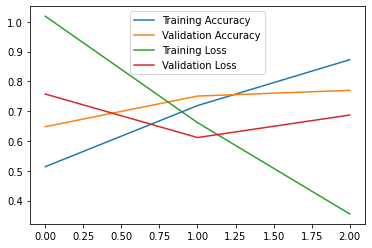

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history['sparse_categorical_accuracy'])
plt.plot(history.epoch, history.history['val_sparse_categorical_accuracy'])
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.legend(['Training Accuracy', 'Validation Accuracy', 
            'Training Loss', 'Validation Loss'])

704/704 [==============================] - 6s 9ms/sample
Accuracy: 0.3778409090909091
macro_f1: 0.32672165815419724
micro_f1:0.3778409090909091
weighted_f1:0.3554822613327884


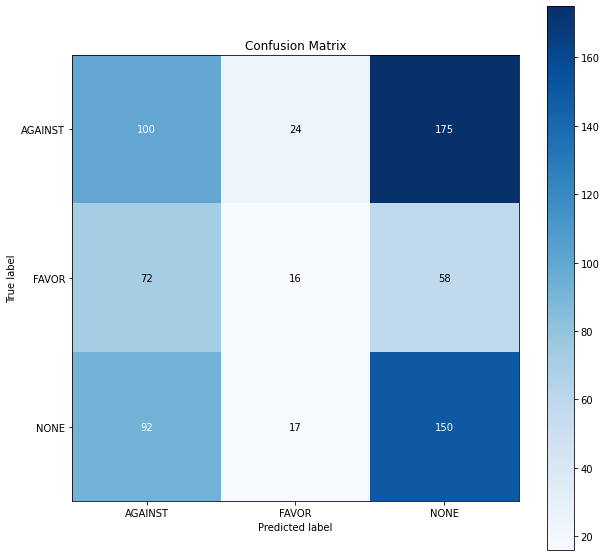

In [28]:
! pip install -q scikit-plot
import scikitplot as skplt
from sklearn.metrics import accuracy_score, f1_score

#@title Get test set predictions.
predicts = model.predict(test_x, verbose=True).argmax(axis=-1)

accuracy = accuracy_score(test_y, predicts)
macro_f1 = f1_score(test_y, predicts, average='macro')
micro_f1 = f1_score(test_y, predicts, average='micro')
weighted_f1 = f1_score(test_y, predicts, average='weighted')

print("Accuracy: %s" % accuracy)
print ('macro_f1: %s\nmicro_f1:%s\nweighted_f1:%s' %(
    macro_f1, micro_f1, weighted_f1)
)

id_to_labels = {0:'FAVOR', 1:'AGAINST', 2:'NONE'}
skplt.metrics.plot_confusion_matrix(
    [id_to_labels[x] for x in test_y], 
    [id_to_labels[x] for x in predicts],
    figsize=(10,10))
  

In [13]:
from google.colab import files
data_upload=files.upload()

blm_df = pd.read_excel('newTweets.xlsx', index_col=None, header=0)
blm_df.head()

blmTweets=[]
for i, row in blm_df.iterrows():
  blmTweets.append(row['text'])

print(len(blmTweets))

Saving newTweets.xlsx to newTweets.xlsx
1000


In [29]:
stances=[]
for text in blmTweets:
  text=clean_my_text(text)
  ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
  inpu = np.array(ids).reshape([1, SEQ_LEN])
  predicted_id = model.predict([inpu,np.zeros_like(inpu)]).argmax(axis=-1)[0]
  print ("%s: %s"% (id_to_labels[predicted_id], text))
  stances.append(id_to_labels[predicted_id])

print(stances)

NONE: arrest the cops who killed breonna taylor  JusticeForBreonnaTaylor  BLM ✊🏾🖤 
AGAINST: Bow Tie check!  Seahawks at  Falcons   BLM  EndRacism 
NONE: justice for Breonna Taylor  blm  TuscanGP 
NONE: This...  Champion...  Again...  (Thank you  naomiosaka   BLM ) 
AGAINST: You hear conservatives talk all the time about how they want to “disrupt the nuclear family” and that it’s bad. But do you know why?  Because the  BLM creators who are self claimed MARXISTS know that breaking up the family makes it easier to abolish private property.  RUN
NONE: I don’t have a national  regional  or even a local voice; BUT I do have A voice. And I feel the need to start using it.  BLM 
AGAINST: Don’t believe race-baiting lies. There are FOUR people here and one man shouts “I hope they die” at    seconds in  after the shooting in Compton. That’s terrible and he was rightly arrested. But these four clowns do NOT equal  BLM. Protestors in general NOT wishing death on cops. 
AGAINST: Hamilton’s message f

In [30]:
blm_df.insert(loc=0, column='stance',value=stances)

In [31]:
writer = pd.ExcelWriter('stanceBLM.xlsx')
blm_df.to_excel(writer, 'newsheet' )
writer.save()

In [32]:
files.download('stanceBLM.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>